# Section 3.1 Single Model Visual Diagnostics
*How can we determine that our Markov Chain Monte Carlo inference run has converged?*

In [1]:
import os
import time

import arviz as az
import numpy as np
import pymc3 as pm
import scipy.stats as stats

# Change working directory
if os.path.split(os.getcwd())[-1] != "notebooks":
    os.chdir(os.path.join(".."))

from utils import metropolis_hastings

NETCDF_DIR = "inference_data"

np.random.seed(0)

In [2]:
az.style.use('arviz-white')

## Learning Objectives
* Understand Hamiltonian Monte Carlo sampler basics
* Visualize and interpret single model diagnostics such as the trace plot and autocorrelation plot
* Calculate and interpret single model diagnostic calculations 
* Gain proficiency with Xarray, NetCDF, and az.InferenceData objects

## MCMC is great but its not perfect

Recall that Monte Carlo Markov Chain are handy mathematical trick that let's us compute posteriors, without needing to compute the denominator of Bayes rule, but it has tradeoffs. Most notably **finite MCMC chains are not guaranteed to converge to the true parameter value**.

This is not to say finite MCMC chains are always wrong, but it does mean that when using MCMC inference methods it is prudent to check the result's diagnostic methods. In this tutorial we'll cover both numerical and visual methods.

### Desirable characteristics in MCMC chains

Bayesian MCMC modelers want *a large number of samples from well mixed chains*. Typically this indicates that *the chains are stationary and have converged*. We'll illustrate the meaning and intuition behind these statements below.

## A story of two inference runs

In demonstrating what good and "bad" diagnostics look like we will be reusing our Metropolis Hasting sampler. 

Recall that our data has been generated from the following distribution

$$ 
\mu \sim \mathcal{N}(10, 1) \\
y \sim \mathcal{N}(\mu + 20,1) 
$$

In the real world, we might not observe the data generating process. Let's see if we can get there using inference.

First, we generate some data:

In [3]:
data = stats.norm.rvs(loc=30, scale=1, size=1000).flatten()

## Visual Diagnostics
### Traceplot

Traceplots help us "trace" the steps of the MCMC chain. Things to look for in traceplots are 
* Mixing of chains
* No long regions of monoticity 

This indicates that the MCMC chain is able to readily sampling the posterior distribution and provide some confidence that regions of the posterior are not being excluded. Traceplots can help diagnose problems such as 

* Multimodal posteriors
* Bad initialization
* Difficult sampling topologies (such as Neal's funnel)

Typically you'll hear that traceplots should look like "fuzzy" caterpillars. In ArviZ `plot_trace` returns a traceplot for each variable on the right column, and on the left a kde plot, for continuous variables, or histogram for discrete variables.

### Example 1: Bad initialization
Recall that MCMC is very sensitive to starting points of each chain, similar to gradient descent or random weights in Neural Nets. To illustrate example let's "randomly" pick -50 and 60 as our starting points for each chain.

In [4]:
# "Randomly" pick -50 and 60 as start points
samples = 200
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=60)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=-50)
data_bad_init = az.from_dict({"θ":[chain_0, chain_1]}, dims={"chain":[0, 1]})
data_bad_init.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 200)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
Data variables:
    θ        (chain, draw) float64 60.0 60.0 59.79 ... -6.621 -6.601 -6.288
Attributes:
    created_at:  2019-06-13T01:20:26.296648

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b0b7f7dd8>,
      dtype=object)

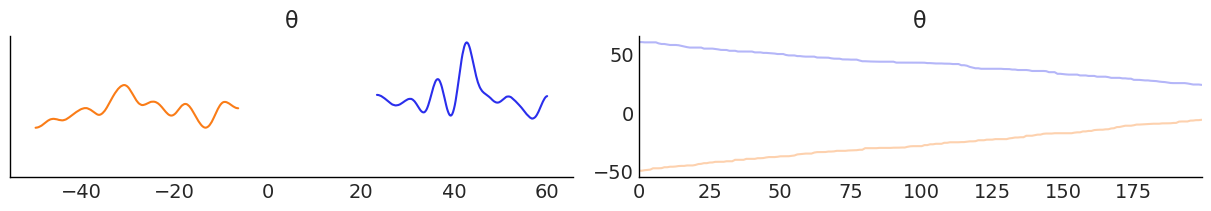

In [5]:
az.to_netcdf(data_bad_init, os.path.join(NETCDF_DIR, "data_bad_init.nc"))
az.plot_trace(data_bad_init)

In this traceplot the chains have not converged to a single value. Both seem to be trending towards a value, but that value hasn't been reached. Additionally the two chains are not "mixing": we claim that they are sampling from the same distribution, so we should see similar density plots from both chains.

In practice picking initialization points a challenge and a [number of strategies exist](https://docs.pymc.io/api/inference.html)

#### Suggested actions

* Run the chains for longer, if you can
* Try different initialization strategies
* Run inference across more chains in different points

### Example 2: Better starting points, no warmup Period

For purposes of learning we'll cheat again and manually set favorable (close to 10) using prior knowledge, and then start running inference.

However the first 20 samples are concerning as they seem to have a trend, and rather than exploring the posterior seem to still be in the process of converging. It is common practice to discard a fixed number of early samples, in a process called "warm up", or "burn-in".

In [6]:
# "Better" chain starting points of 8 and 13
samples = 200
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=8)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=13)
data_good_init = az.from_dict({"θ":[chain_0, chain_1]}, dims={"chain":[0, 1]});

In [7]:
az.to_netcdf(data_good_init, os.path.join(NETCDF_DIR, "data_good_init.nc"))
data_good_init

Inference data with groups:
	> posterior

In [8]:
data_good_init.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 200)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
Data variables:
    θ        (chain, draw) float64 8.0 8.0 8.0 9.021 ... 9.967 9.967 9.967 9.967
Attributes:
    created_at:  2019-06-13T01:20:26.910834

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b04147860>,
      dtype=object)

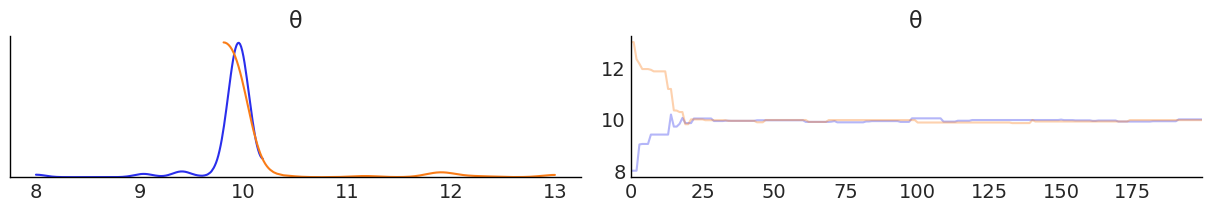

In [9]:
az.plot_trace(data_good_init)

The chains seem to have converged this time, reaching the approximate value of 10 even though they started above and below their final value. This gives us confidence that 10 is a correct value for the posterior. Still there are issues, Each individual chain seems to have only sampled one side of the distribution, and there clearly is a region at the start `of correlated progress.

#### Suggested Actions
From the traceplot it looks like this model needs time to "warmup". Warmup samples are ones that samples that are discarded at the start of the chain while the chains begin to converge. 

* Discard samples near the start of a chain 

### Example: Same trace with warm up period
In our simple sampler we can discard the first 20 samples as warmup samples. This value was determined by looking at the trace plot and approximating where the chains meet.

Note: Another term you might see is [burn in](https://statmodeling.stat.columbia.edu/2017/12/15/burn-vs-warm-iterative-simulation-algorithms/). There's some nuances as to why it may be different, but the essence is the same, use the first part of the chain to "get settled" and disregard those samples when estimating the posterior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b04059d30>,
      dtype=object)

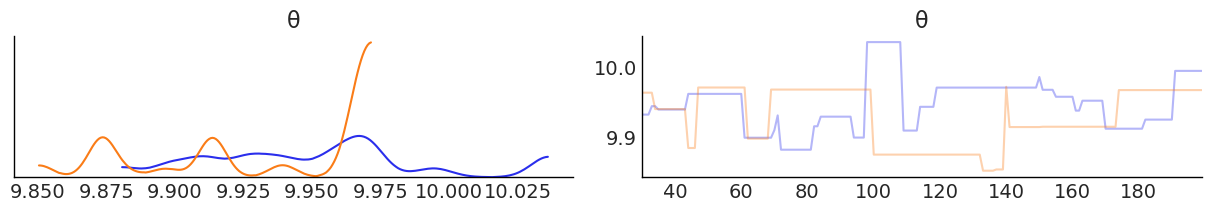

In [10]:
az.plot_trace(data_good_init.posterior.sel(draw=slice(30, None)))

This is a little better, the chains are now mixing fairly well and holding to a tight boundary. However the posterior plot and traceplot still raise concerns. The traceplot is still fairly "jagged" and which is also reflected a very odd distribution in the posterior plot. The Metropolis Hastings algorithm seems to have trouble exploring the distribution. One thing we could do is tune the Metropolis-Hasting sampler, remember that there is a proposal distribution and acceptance criteria. By tuning these we could do better, and most libraries will do this automatically.

For many models of interest, no amount of tuning will help, and the recommendation is to take a lot more samples. 

#### Suggestions

* Tune the Metropolis-Hastings sampler
* Take a lot more samples

### Example: Same sampler with a lot more samples

There are results that suggest accepting 23.4% of proposals in Metropolis-Hastings is optimal, and the routine in PyMC3 for achieving that is a 20 line `switch` statement. 

However, thinking back to the theory, if we have sample an infinite amount of times then the samples will converge to the true posterior distribution. Let's just do the easy thing and run more samples.

Extra Credit: Sometimes convergence is only achieved in the limit! Mixture models are a good example.

In [11]:
start = time.time()

samples = 20000
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=8)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=13)
data_good_init_long_chain = az.from_dict({"θ":[chain_0, chain_1]}, dims={"chain":[0, 1]})

print(time.time()-start)

14.617278337478638


In [12]:
az.to_netcdf(data_good_init_long_chain, os.path.join(NETCDF_DIR, "data_good_init_long_chain.nc"))
data_good_init_long_chain.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 20000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 19994 19995 19996 19997 19998 19999
Data variables:
    θ        (chain, draw) float64 8.0 8.0 8.0 8.0 ... 9.945 9.945 9.945 9.945
Attributes:
    created_at:  2019-06-13T01:20:42.325404

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b03f8b898>,
      dtype=object)

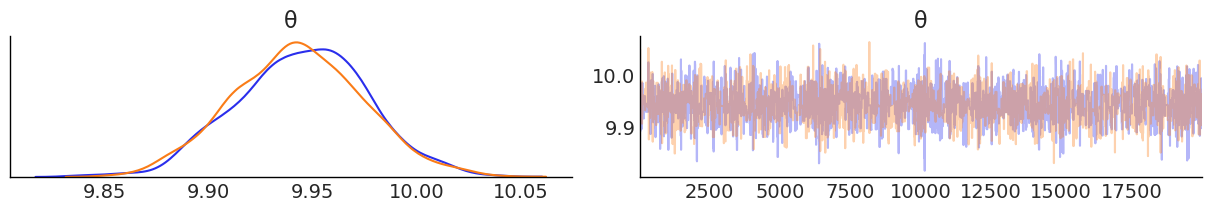

In [13]:
az.plot_trace(data_good_init_long_chain.posterior.sel(draw=slice(30, None)))

After 14 seconds on this computer the results look better. The traceplot is resembles a "fuzzy caterpillar", and both posterior chains look like a normal distribution, and more closely resemble each other. By taking a lot more samples we're able to get a posterior distribution that plausibly could be $\mu$. 
  
We can use the same the strategy with the bad initialization as well if we take more samples and wait a bit longer.

In [14]:
start = time.time()

# "Randomly" pick -50 and 60 as start points but take a lot more samples this time
samples = 40000
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=60)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=-50)
data_bad_init_longer_chain = az.from_dict({"θ":[chain_0, chain_1]}, dims={"chain":[0, 1]})

print(time.time()-start)

33.37716555595398


In [15]:
az.to_netcdf(data_bad_init_longer_chain, os.path.join(NETCDF_DIR, "data_bad_init_longer_chain.nc"))
data_bad_init_longer_chain.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 40000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 39994 39995 39996 39997 39998 39999
Data variables:
    θ        (chain, draw) float64 59.67 59.67 59.66 59.66 ... 9.909 9.909 10.0
Attributes:
    created_at:  2019-06-13T01:21:16.149397

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b03ede400>,
      dtype=object)

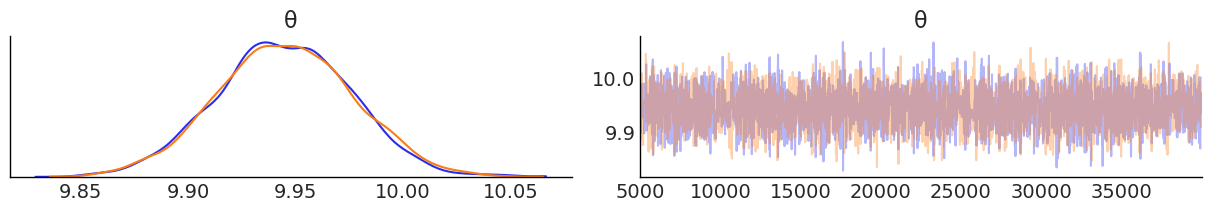

In [16]:
az.plot_trace(data_bad_init_longer_chain.posterior.sel(draw=slice(5000, None)))

After 30 seconds we have results. We need to throw away more samples, arbitrarily picking 5,000, but the resulting plots look even better, and all we needed to do is wait longer. This is great news if you have infinite time and computing power. Unfortunately most humans don't live an infinite time span, nor do they want to be at work for an infinite amount of time so we need to do better.

Historical note: Metropolis-Hastings was one of the "10 Most Important Algorithms of the 20th Century". Sampling from high dimensional models could call for millions, billions, or trillions of samples, which also lead to more careful implementations that were memory efficient.

### Tuned Metropolis Hastings
In our basic version of Metropolis Hastings the acceptance threshold for a proposal, and the proposal width stayed fixed. Improved implemented of Metropolis Hastings, such as the one in PyMC3, perform some tuning first to determine parameters better fitted to the model and data, and use those instead. 

In [17]:
with pm.Model() as basic_model:
    θ = pm.Normal("θ", 0, 20)
    y = pm.Normal("y", mu=θ+20, observed=data)
    step = pm.Metropolis() 
    trace = pm.sample(5000, tune=1000, chains=2, step=step)

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [θ]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:00<00:00, 12143.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2af055da58>,
      dtype=object)

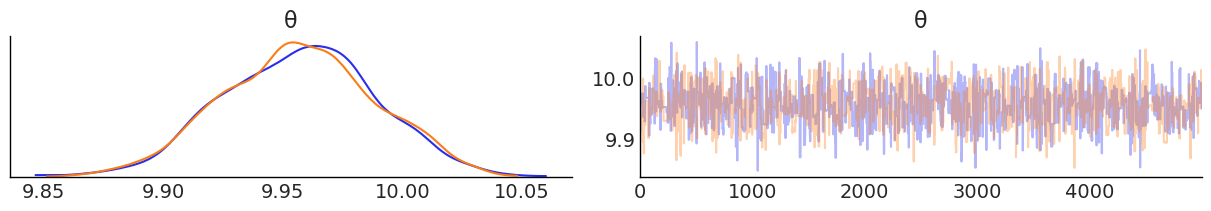

In [18]:
data_tuned_mh = az.from_pymc3(trace=trace)
az.to_netcdf(data_tuned_mh, os.path.join(NETCDF_DIR, "data_tuned_mh.nc"))
az.plot_trace(data_tuned_mh)

Even though we're using the same class of MCMC sampler, Metropolis Hastings, notice how much better both the KDE and traceplot look. This highlights one of the benefits of using a PPL. In addition to getting an easier syntax to define models, PPLs come prepackaged with more sophisticated implementations of algorithms. Metropolis Hastings is just the start.

### Hamiltonian Monte Carlo: Better Living Through Physics

Stealing a title and quoting directly from [Richard McElreath's blog](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/)  

*If there’s a random way to do something, there’s usually a less random way that is both better and requires more thought. Instead of making random proposals, suppose instead that you run a physics simulation. This is going to sound crazy, but it isn’t.*  

What's he's referring to is the Hamiltonian class of samplers. At the core these samplers use principles from physics to select next points, think of riding a roller coaster with your eyes shut. By feeling how fast a roller coaster is going, you can deduce if you're at the bottom of the ride, or at the top. In addition to physics simulations, PPLs such as PyMC3 and Stan implement various other tricks, called tuning, to help a Bayesian modeler (usually) get good samples quickly with minimal fuss.

In [19]:
with pm.Model() as basic_model:
    θ = pm.Normal("θ", 0, 20)
    y = pm.Normal("y", mu=θ+20, observed=data)
    trace = pm.sample(1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4091.03draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b06c3d978>,
      dtype=object)

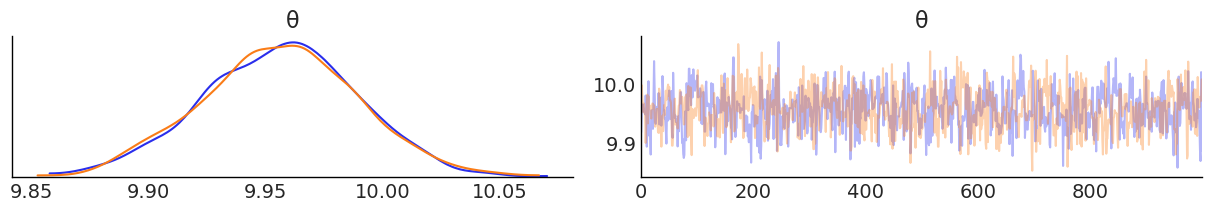

In [20]:
data_hmc = az.from_pymc3(trace=trace)
az.to_netcdf(data_hmc, os.path.join(NETCDF_DIR, "data_hmc.nc"))
az.plot_trace(data_hmc)

In [21]:
data_hmc.sample_stats

<xarray.Dataset>
Dimensions:               (chain: 2, draw: 1000, log_likelihood_dim_0: 1000)
Coordinates:
  * chain                 (chain) int64 0 1
  * draw                  (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * log_likelihood_dim_0  (log_likelihood_dim_0) int64 0 1 2 3 ... 997 998 999
Data variables:
    energy                (chain, draw) float64 1.411e+03 ... 1.412e+03
    step_size             (chain, draw) float64 1.671 1.671 ... 1.492 1.492
    tree_size             (chain, draw) float64 3.0 3.0 3.0 1.0 ... 3.0 1.0 1.0
    lp                    (chain, draw) float64 -1.411e+03 ... -1.411e+03
    diverging             (chain, draw) bool False False False ... False False
    step_size_bar         (chain, draw) float64 1.429 1.429 1.429 ... 1.4 1.4
    tune                  (chain, draw) bool True False False ... False False
    depth                 (chain, draw) int64 2 2 2 1 2 2 2 2 ... 2 2 2 2 2 1 1
    mean_tree_accept      (chain, draw) float64 0.8467 0

## Autocorrelation Plot
Another method to check convergence is to see if the samples are linearly correlated with each other. Auto just means checking correlation in the same chain.
The formula for autocorrelation is as follows

$$\large \rho_{lag} = \frac{\Sigma_{i=0}^{N-lag} (\theta_{i} - \overline{\theta})(\theta_{i + lag} - \overline{\theta})}{\Sigma_{i=0}^{N}(\theta_{i} - \overline{\theta})^2}$$


### Highly correlated chain
We'll make some fake chains to illustrate. For one extreme let's create a fake chain that's as correlated as you can get, a straight line.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b06c50da0>]],
      dtype=object)

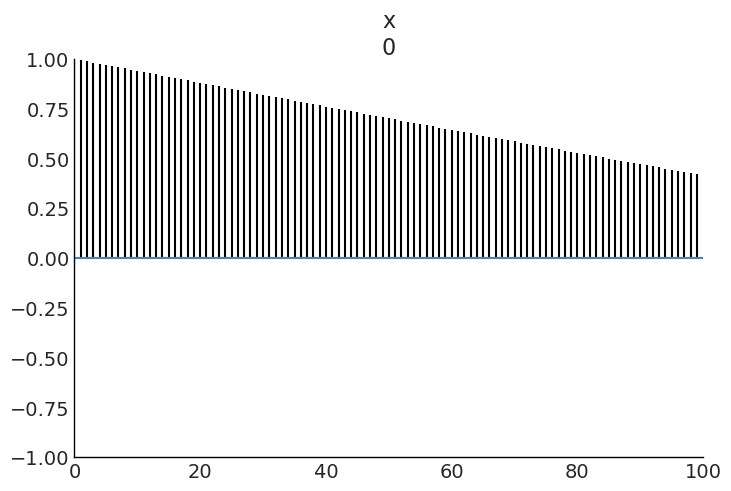

In [22]:
chain = np.arange(500)
az.plot_autocorr(chain)

If we look at value 40, the value indicates `chain[0:(500-40)]` still has about a .75 value of correlation with `chain[40:500]`. Remember that we're looking for that "fuzzy caterpillar" and in math terms that means random behavior. If our chain has converged it shouldn't be trending in just one direction.

Contrast the above chain with random draws from a normal distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b44451a58>]],
      dtype=object)

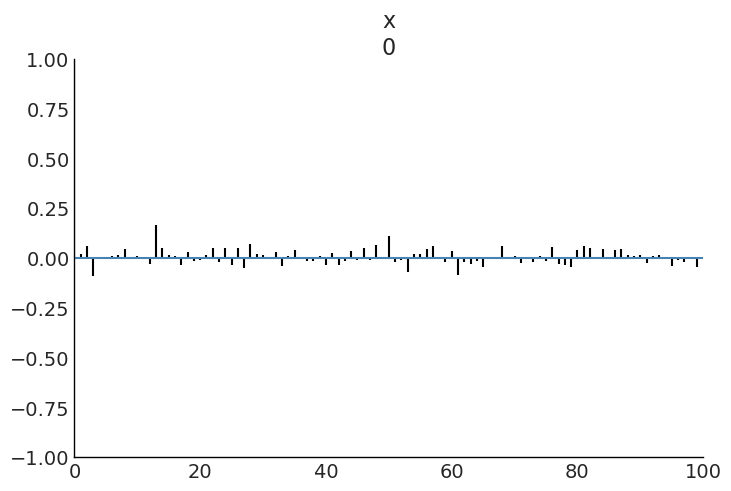

In [23]:
chain = stats.norm.rvs(0,1,size=500)
az.plot_autocorr(chain)

Values closer to zero indicate that the chain behavior is more random, and that there aren't long regions of linear patterns in the chain. In a converged chain this is the expected behavior. In the following notebook we'll be analyzing the datasets above with autocorrelation plots to get further practice for their interpretation.